Google slide link : https://docs.google.com/presentation/d/140DI2ckkfrvidNeKJZCIhGBw5QhiYMYKULExHGGqnWE/edit?usp=drive_open&ouid=112066658147094722790

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

#Stacked auto encoder
from keras.layers import *
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, RepeatVector


#Random Forest Model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=500, random_state=1)

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')

os.environ["KMP_DUPLICATE_LIB_OK"]="True"
from pandas import read_csv
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Input, Dense, GRU, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
def process_FAA_hourly_data(filename):
    path = os.getcwd()
    pathfile = os.path.join(path,"Data",filename)
    df_temps = pd.read_csv(pathfile, skiprows=16)
    df_temps = df_temps.iloc[:,:-1]
    df_temps = df_temps.loc[df_temps[df_temps.columns[0]] != df_temps.columns[0]]
    df_temps[df_temps.columns[1]] = df_temps[df_temps.columns[1]].apply(pd.to_numeric, downcast = "integer")
    df_temps[df_temps.columns[2:]] = df_temps[df_temps.columns[2:]].apply(pd.to_numeric, downcast = "float")
    df_temps = df_temps.set_index(pd.DatetimeIndex(df_temps[df_temps.columns[0]]))
    df_temps = df_temps.drop([df_temps.columns[0]], axis=1)
    return df_temps

In [27]:
df_kphl = process_FAA_hourly_data("faa_hourly-KPHL_20120101-20190101.csv")
df_kabe = process_FAA_hourly_data("faa_hourly-KABE_20120101-20190101.csv")
df_kacy = process_FAA_hourly_data("faa_hourly-KACY_20120101-20190101.csv")
df_kttn = process_FAA_hourly_data("faa_hourly-KTTN_20120101-20190101.csv")
df_klns = process_FAA_hourly_data("faa_hourly-KLNS_20120101-20190101.csv")

In [28]:
df_kphl.head()

,Number of Observations (n/a),Average Temp (F),Max Temp (F),Min Temp (F),Average Dewpoint Temp (F),1 Hour Precip (in),Max Wind Gust (mph),Average Relative Humidity (%),Average Wind Speed (mph),Average Station Pressure (mb),Average Wind Direction (deg),Max Wind Speed (mph)
Date/Time (GMT),,,,,,,,,,,,
2012-01-01 00:00:00,1,52.000000,52.000000,52.000000,36.000000,NaN,NaN,54.0,10.4,1016.900024,290.0,10.4
2012-01-01 01:00:00,1,51.099998,51.099998,51.099998,36.000000,NaN,NaN,56.0,10.4,1017.599976,280.0,10.4
2012-01-01 02:00:00,1,51.099998,51.099998,51.099998,36.000000,NaN,19.6,56.0,15.0,1018.299988,290.0,15.0
2012-01-01 03:00:00,1,50.000000,50.000000,50.000000,36.000000,NaN,NaN,58.0,13.8,1019.000000,280.0,13.8
2012-01-01 04:00:00,1,48.900002,48.900002,48.900002,35.099998,NaN,NaN,59.0,8.1,1019.000000,300.0,8.1


In [29]:
df_kphl_useful = df_kphl.iloc[:,[1,7,8,9,10]]
df_kabe_useful = df_kabe.iloc[:,[1,7,8,9,10]]
df_kacy_useful = df_kacy.iloc[:,[1,7,8,9,10]]
df_kttn_useful = df_kttn.iloc[:,[1,7,8,9,10]]
df_klns_useful = df_klns.iloc[:,[1,7,8,9,10]]

In [30]:
start = df_kphl_useful.index[0]
end = df_kphl_useful.index[-1]
idx = pd.date_range(start, end, freq='H')

df_kphl_useful = df_kphl_useful.reindex(idx, fill_value = np.nan)
df_kabe_useful = df_kabe_useful.reindex(idx, fill_value = np.nan)
df_kacy_useful = df_kacy_useful.reindex(idx, fill_value = np.nan)
df_kttn_useful = df_kttn_useful.reindex(idx, fill_value = np.nan)
df_klns_useful = df_klns_useful.reindex(idx, fill_value = np.nan)

df_kphl_useful["Date/Time (GMT)"] = idx
df_kphl_useful = df_kphl_useful.set_index(pd.DatetimeIndex(df_kphl_useful[df_kphl_useful.columns[5]]))
df_kabe_useful["Date/Time (GMT)"] = idx
df_kabe_useful = df_kabe_useful.set_index(pd.DatetimeIndex(df_kabe_useful[df_kabe_useful.columns[5]]))
df_kacy_useful["Date/Time (GMT)"] = idx
df_kacy_useful = df_kacy_useful.set_index(pd.DatetimeIndex(df_kacy_useful[df_kacy_useful.columns[5]]))
df_kttn_useful["Date/Time (GMT)"] = idx
df_kttn_useful = df_kttn_useful.set_index(pd.DatetimeIndex(df_kttn_useful[df_kttn_useful.columns[5]]))
df_klns_useful["Date/Time (GMT)"] = idx
df_klns_useful = df_klns_useful.set_index(pd.DatetimeIndex(df_klns_useful[df_klns_useful.columns[5]]))


df_kphl_useful = df_kphl_useful.drop(columns=["Date/Time (GMT)"])
df_kabe_useful = df_kabe_useful.drop(columns=["Date/Time (GMT)"])
df_kacy_useful = df_kacy_useful.drop(columns=["Date/Time (GMT)"])
df_kttn_useful = df_kttn_useful.drop(columns=["Date/Time (GMT)"])
df_klns_useful = df_klns_useful.drop(columns=["Date/Time (GMT)"])

df_kphl_useful = df_kphl_useful.fillna(method = "ffill")
df_kabe_useful = df_kabe_useful.fillna(method = "ffill")
df_kacy_useful = df_kacy_useful.fillna(method = "ffill")
df_kttn_useful = df_kttn_useful.fillna(method = "ffill")
df_klns_useful = df_klns_useful.fillna(method = "ffill")

In [31]:
df_kphl_useful.head()

,Average Temp (F),Average Relative Humidity (%),Average Wind Speed (mph),Average Station Pressure (mb),Average Wind Direction (deg)
Date/Time (GMT),,,,,
2012-01-01 00:00:00,52.000000,54.0,10.4,1016.900024,290.0
2012-01-01 01:00:00,51.099998,56.0,10.4,1017.599976,280.0
2012-01-01 02:00:00,51.099998,56.0,15.0,1018.299988,290.0
2012-01-01 03:00:00,50.000000,58.0,13.8,1019.000000,280.0
2012-01-01 04:00:00,48.900002,59.0,8.1,1019.000000,300.0


Adding hour data label

In [32]:
df_kphl_useful['hours'] = df_kphl_useful.index.hour
df_kabe_useful['hours'] = df_kabe_useful.index.hour
df_kacy_useful['hours'] = df_kacy_useful.index.hour
df_klns_useful['hours'] = df_klns_useful.index.hour
df_kttn_useful['hours'] = df_kttn_useful.index.hour

In [33]:
df_kphl_useful.head()

,Average Temp (F),Average Relative Humidity (%),Average Wind Speed (mph),Average Station Pressure (mb),Average Wind Direction (deg),hours
Date/Time (GMT),,,,,,
2012-01-01 00:00:00,52.000000,54.0,10.4,1016.900024,290.0,0
2012-01-01 01:00:00,51.099998,56.0,10.4,1017.599976,280.0,1
2012-01-01 02:00:00,51.099998,56.0,15.0,1018.299988,290.0,2
2012-01-01 03:00:00,50.000000,58.0,13.8,1019.000000,280.0,3
2012-01-01 04:00:00,48.900002,59.0,8.1,1019.000000,300.0,4


## Scale and Combine DFs to Get Variable Distributions

In [34]:
df_kphl_useful_scaled = df_kphl_useful.copy()
df_kabe_useful_scaled = df_kabe_useful.copy()
df_kacy_useful_scaled = df_kacy_useful.copy()
df_klns_useful_scaled = df_klns_useful.copy()
df_kttn_useful_scaled = df_kttn_useful.copy()

In [35]:
scaler_kphl = MinMaxScaler()
df_kphl_useful_scaled[[df_kphl_useful_scaled.columns[0],df_kphl_useful_scaled.columns[1],df_kphl_useful_scaled.columns[2],df_kphl_useful_scaled.columns[3],df_kphl_useful_scaled.columns[4]]] = scaler_kphl.fit_transform(df_kphl_useful_scaled[[df_kphl_useful_scaled.columns[0],df_kphl_useful_scaled.columns[1],df_kphl_useful_scaled.columns[2],df_kphl_useful_scaled.columns[3],df_kphl_useful_scaled.columns[4]]])

scaler_kabe = MinMaxScaler()
df_kabe_useful_scaled[[df_kphl_useful_scaled.columns[0],df_kphl_useful_scaled.columns[1],df_kphl_useful_scaled.columns[2],df_kphl_useful_scaled.columns[3],df_kphl_useful_scaled.columns[4]]] = scaler_kabe.fit_transform(df_kabe_useful_scaled[[df_kphl_useful_scaled.columns[0],df_kphl_useful_scaled.columns[1],df_kphl_useful_scaled.columns[2],df_kphl_useful_scaled.columns[3],df_kphl_useful_scaled.columns[4]]])

scaler_kacy = MinMaxScaler()
df_kacy_useful_scaled[[df_kphl_useful_scaled.columns[0],df_kphl_useful_scaled.columns[1],df_kphl_useful_scaled.columns[2],df_kphl_useful_scaled.columns[3],df_kphl_useful_scaled.columns[4]]] = scaler_kacy.fit_transform(df_kacy_useful_scaled[[df_kphl_useful_scaled.columns[0],df_kphl_useful_scaled.columns[1],df_kphl_useful_scaled.columns[2],df_kphl_useful_scaled.columns[3],df_kphl_useful_scaled.columns[4]]])

scaler_klns = MinMaxScaler()
df_klns_useful_scaled[[df_kphl_useful_scaled.columns[0],df_kphl_useful_scaled.columns[1],df_kphl_useful_scaled.columns[2],df_kphl_useful_scaled.columns[3],df_kphl_useful_scaled.columns[4]]] = scaler_klns.fit_transform(df_klns_useful_scaled[[df_kphl_useful_scaled.columns[0],df_kphl_useful_scaled.columns[1],df_kphl_useful_scaled.columns[2],df_kphl_useful_scaled.columns[3],df_kphl_useful_scaled.columns[4]]])

scaler_kttn = MinMaxScaler()
df_kttn_useful_scaled[[df_kphl_useful_scaled.columns[0],df_kphl_useful_scaled.columns[1],df_kphl_useful_scaled.columns[2],df_kphl_useful_scaled.columns[3],df_kphl_useful_scaled.columns[4]]] = scaler_kttn.fit_transform(df_kttn_useful_scaled[[df_kphl_useful_scaled.columns[0],df_kphl_useful_scaled.columns[1],df_kphl_useful_scaled.columns[2],df_kphl_useful_scaled.columns[3],df_kphl_useful_scaled.columns[4]]])

In [37]:
df_kphl_useful_scaled.head()

,Average Temp (F),Average Relative Humidity (%),Average Wind Speed (mph),Average Station Pressure (mb),Average Wind Direction (deg),hours
Date/Time (GMT),,,,,,
2012-01-01 00:00:00,0.500511,0.262195,0.222080,0.691548,0.805556,0
2012-01-01 01:00:00,0.491318,0.274390,0.222080,0.699231,0.777778,1
2012-01-01 02:00:00,0.491318,0.274390,0.320307,0.706915,0.805556,2
2012-01-01 03:00:00,0.480082,0.286585,0.294683,0.714599,0.777778,3
2012-01-01 04:00:00,0.468846,0.292683,0.172966,0.714599,0.833333,4


In [38]:
df_kphl_useful_scaled.describe()

,Average Temp (F),Average Relative Humidity (%),Average Wind Speed (mph),Average Station Pressure (mb),Average Wind Direction (deg),hours
count,61392.000000,61392.000000,61392.000000,61392.000000,61392.000000,61392.000000
mean,0.553999,0.312977,0.191571,0.700306,0.535282,11.500000
std,0.186926,0.118892,0.112481,0.083013,0.303545,6.922243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.404188,0.219512,0.123852,0.647640,0.250000,5.750000
50%,0.560776,0.310976,0.172966,0.699231,0.583333,11.500000
75%,0.711670,0.414634,0.245569,0.751921,0.788889,17.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000


In [39]:
def eda_plots(df, color):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

    temp_data = df[df.columns[0]]
    humidity_data = df[df.columns[1]]
    windSpeed_data = df[df.columns[2]]
    pressure_data = df[df.columns[3]]
    windDirection_data = df[df.columns[4]]

    axs[0, 0].scatter(df.index, temp_data, alpha = 0.8, color=color, edgecolors='none', s=2)
    axs[0, 0].set_title("Average Temperature Plot")
    axs[0, 0].set_xlabel("Day/Time (GMT)")
    axs[0, 0].set_ylabel("Average Temperature (scaled)")

    axs[0, 1].scatter(df.index, humidity_data, alpha = 0.8, color=color, edgecolors='none', s=2)
    axs[0, 1].set_title("Average Humidity Plot")
    axs[0, 1].set_xlabel("Day/Time (GMT)")
    axs[0, 1].set_ylabel("Average Humidity (scaled)")

    axs[1, 0].scatter(df.index, windSpeed_data, alpha = 0.8, color=color, edgecolors='none', s=2)
    axs[1, 0].set_title("Average Wind Speed Plot")
    axs[1, 0].set_xlabel("Day/Time (GMT)")
    axs[1, 0].set_ylabel("Average Wind Speed (scaled)")

    axs[1, 1].scatter(df.index, pressure_data, alpha = 0.8, color=color, edgecolors='none', s=2)
    axs[1, 1].set_title("Average Pressure Plot")
    axs[1, 1].set_xlabel("Day/Time (GMT)")
    axs[1, 1].set_ylabel("Average Pressure (scaled)")
    
    axs[0, 2].scatter(df.index, windDirection_data, alpha = 0.8, color=color, edgecolors='none', s=2)
    axs[0, 2].set_title("Wind Direction Plot")
    axs[0, 2].set_xlabel("Day/Time (GMT)")
    axs[0, 2].set_ylabel("Wind Direction (scaled)")
    
    axs[1, 2].remove()

    plt.show()

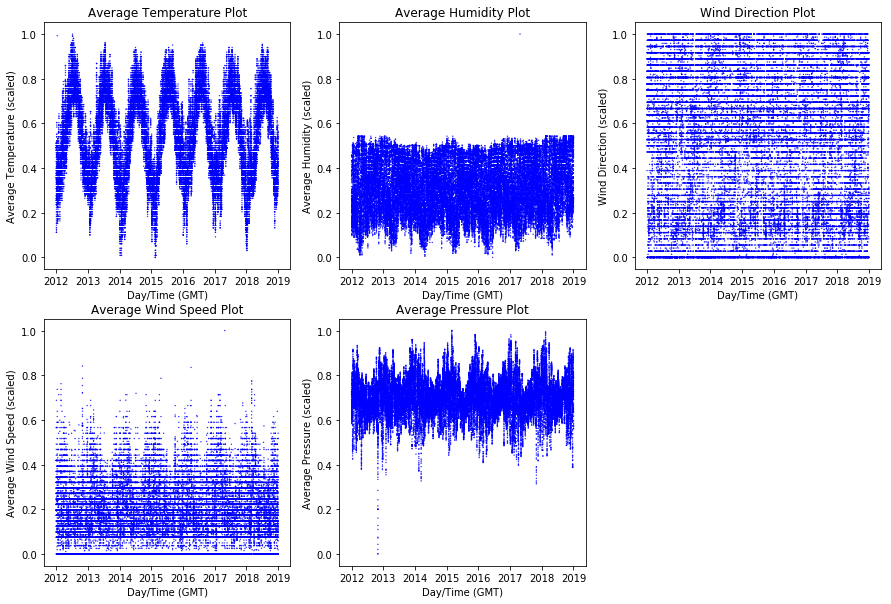

In [40]:
eda_plots(df_kphl_useful_scaled, 'b')

## Create Distance Matrix for Each Station, Variable

In [41]:
#concatenate all df's together

def concat_df(col_name):
    df_all = pd.DataFrame()
    df_all = df_kphl_useful[[col_name]]
    
    df_all['kphl'] = df_kphl_useful_scaled[[col_name]]
    df_all['kabe'] = df_kabe_useful_scaled[[col_name]]
    df_all['kacy'] = df_kacy_useful_scaled[[col_name]]
    df_all['klns'] = df_klns_useful_scaled[[col_name]]
    df_all['kttn'] = df_kttn_useful_scaled[[col_name]]

    df_all.drop(col_name, axis=1, inplace=True)

    return(df_all)

In [42]:
#find absolute difference between kphl and all other df's

def concat_dist(df_all):  
    df_all['dist_kabe'] = abs(df_all['kphl'] - df_all['kabe'])
    df_all['dist_kacy'] = abs(df_all['kphl'] - df_all['kacy'])
    df_all['dist_klns'] = abs(df_all['kphl'] - df_all['klns'])
    df_all['dist_kttn'] = abs(df_all['kphl'] - df_all['kttn'])

    return(df_all)

In [43]:
temp_df = concat_df('Average Temp (F)')
temp_dist = concat_dist(temp_df)
temp_values = (temp_dist['dist_kabe'].mean(), temp_dist['dist_kacy'].mean(), 
               temp_dist['dist_klns'].mean(), temp_dist['dist_kttn'].mean())

humidity_df = concat_df('Average Relative Humidity (%)')
humidity_dist = concat_dist(humidity_df)
humidity_values = (humidity_dist['dist_kabe'].mean(), humidity_dist['dist_kacy'].mean(), 
                   humidity_dist['dist_klns'].mean(), humidity_dist['dist_kttn'].mean())

windspeed_df = concat_df('Average Wind Speed (mph)')
windspeed_dist = concat_dist(windspeed_df)
windspeed_values = (windspeed_dist['dist_kabe'].mean(), windspeed_dist['dist_kacy'].mean(),
                    windspeed_dist['dist_klns'].mean(), windspeed_dist['dist_kttn'].mean())

pressure_df = concat_df('Average Station Pressure (mb)')
pressure_dist = concat_dist(pressure_df)
pressure_values = (pressure_dist['dist_kabe'].mean(), pressure_dist['dist_kacy'].mean(), 
                   pressure_dist['dist_klns'].mean(), pressure_dist['dist_kttn'].mean())

winddirection_df = concat_df('Average Wind Direction (deg)')
winddirection_dist = concat_dist(winddirection_df)
winddirection_values = (winddirection_dist['dist_kabe'].mean(), winddirection_dist['dist_kacy'].mean(), 
                   winddirection_dist['dist_klns'].mean(), winddirection_dist['dist_kttn'].mean())

In [44]:
kabe_values = (temp_values[0], humidity_values[0], windspeed_values[0], pressure_values[0], winddirection_values[0])
print(kabe_values)

kacy_values = (temp_values[1], humidity_values[1], windspeed_values[1], pressure_values[1], winddirection_values[1])
print(kacy_values)

klns_values = (temp_values[2], humidity_values[2], windspeed_values[2], pressure_values[2], winddirection_values[2])
print(klns_values)

kttn_values = (temp_values[3], humidity_values[3], windspeed_values[3], pressure_values[3], winddirection_values[3])
print(kttn_values)

(0.034836793390262834, 0.29841155435376465, 0.0759770359064317, 0.03569296018057923, 0.1972062175769453)
(0.037898939244895416, 0.347219630306937, 0.07344857499609342, 0.021805151149149687, 0.1614239921192363)
(0.025397072556692688, 0.34685668609629916, 0.07947027489326955, 0.017459419443770944, 0.194778356920448)
(0.019286555865209463, 0.2997911909523933, 0.07257177439085293, 0.016048989639880704, 0.17760593672116193)


In [46]:
#dataframe of distance

df_distance = pd.DataFrame({'kabe': kabe_values, 'kacy': kacy_values, 'klns': klns_values, 'kttn': kttn_values}, 
                            index=['temp', 'humidity', 'wind-speed', 'pressure', 'wind-direction'])
df_distance

,kabe,kacy,klns,kttn
temp,0.034837,0.037899,0.025397,0.019287
humidity,0.298412,0.347220,0.346857,0.299791
wind-speed,0.075977,0.073449,0.079470,0.072572
pressure,0.035693,0.021805,0.017459,0.016049
wind-direction,0.197206,0.161424,0.194778,0.177606


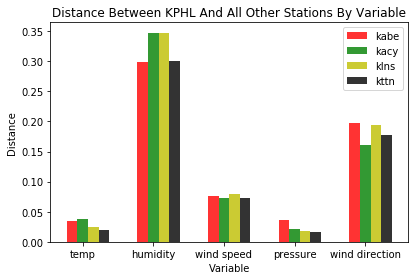

In [47]:
#plot of distances

# create plot
fig, ax = plt.subplots()
index = np.arange(len(kabe_values))
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, kabe_values, bar_width, alpha=opacity, color='r', label='kabe')
rects2 = plt.bar(index+bar_width, kacy_values, bar_width, alpha=opacity, color='g', label='kacy')
rects3 = plt.bar(index+bar_width*2, klns_values, bar_width, alpha=opacity, color='y', label='klns')
rects4 = plt.bar(index+bar_width*3, kttn_values, bar_width, alpha=opacity, color='k', label='kttn')

plt.xlabel('Variable')
plt.ylabel('Distance')
plt.title('Distance Between KPHL And All Other Stations By Variable')
plt.xticks((index + bar_width), ('temp', 'humidity', 'wind speed', 'pressure', 'wind direction'))
plt.legend()

plt.tight_layout()
plt.show()

# combine all five stations and make one dataframe

In [11]:
d = {'kphl' : df_kphl_useful, 
     'kabe' : df_kabe_useful, 
     'kacy' : df_kacy_useful,
     'klns' : df_klns_useful,
     'kttn' : df_kttn_useful,}
df_merge = pd.concat(d.values(), axis=1, keys=d.keys())

In [12]:
df_merge.head()

kphl                                \
                    Average Temp (F) Average Relative Humidity (%)   
Date/Time (GMT)                                                      
2012-01-01 00:00:00        52.000000                          54.0   
2012-01-01 01:00:00        51.099998                          56.0   
2012-01-01 02:00:00        51.099998                          56.0   
2012-01-01 03:00:00        50.000000                          58.0   
2012-01-01 04:00:00        48.900002                          59.0   

                                                                            \
                    Average Wind Speed (mph) Average Station Pressure (mb)   
Date/Time (GMT)                                                              
2012-01-01 00:00:00                     10.4                   1016.900024   
2012-01-01 01:00:00                     10.4                   1017.599976   
2012-01-01 02:00:00                     15.0                   1018.299988   
2012-01-01 03:00:00                     13.8                   1019.000000   
2012-01-01 04:00:00                      8.1                   1019.000000   

                                                                   kabe  \
                    Average Wind Direction (deg) hours Average Temp (F)   
Date/Time (GMT)                                                           
2012-01-01 00:00:00                        290.0     0        46.000000   
2012-01-01 01:00:00                        280.0     1        46.000000   
2012-01-01 02:00:00                        290.0     2        44.099998   
2012-01-01 03:00:00                        280.0     3        41.000000   
2012-01-01 04:00:00                        300.0     4        44.099998   

                                                                            \
                    Average Relative Humidity (%) Average Wind Speed (mph)   
Date/Time (GMT)                                                              
2012-01-01 00:00:00                          73.0                      5.8   
2012-01-01 01:00:00                          73.0                      9.2   
2012-01-01 02:00:00                          76.0                      5.8   
2012-01-01 03:00:00                          82.0                      5.8   
2012-01-01 04:00:00                          79.0                      3.5   

                                                   ...   \
                    Average Station Pressure (mb)  ...    
Date/Time (GMT)                                    ...    
2012-01-01 00:00:00                   1015.900024  ...    
2012-01-01 01:00:00                   1016.299988  ...    
2012-01-01 02:00:00                   1017.299988  ...    
2012-01-01 03:00:00                   1017.900024  ...    
2012-01-01 04:00:00                   1018.299988  ...    

                                        klns                                \
                    Average Wind Speed (mph) Average Station Pressure (mb)   
Date/Time (GMT)                                                              
2012-01-01 00:00:00                     11.5                   1017.299988   
2012-01-01 01:00:00                      8.1                   1017.900024   
2012-01-01 02:00:00                      6.9                   1018.299988   
2012-01-01 03:00:00                      8.1                   1019.000000   
2012-01-01 04:00:00                      0.0                   1019.299988   

                                                                   kttn  \
                    Average Wind Direction (deg) hours Average Temp (F)   
Date/Time (GMT)                                                           
2012-01-01 00:00:00                        290.0     0        50.000000   
2012-01-01 01:00:00                        280.0     1        48.000000   
2012-01-01 02:00:00                        280.0     2        48.000000   
2012-01-01 03:00:00                        260.0     3        46.900002 

In [13]:
df_merge.index

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2019-01-01 14:00:00', '2019-01-01 15:00:00',
               '2019-01-01 16:00:00', '2019-01-01 17:00:00',
               '2019-01-01 18:00:00', '2019-01-01 19:00:00',
               '2019-01-01 20:00:00', '2019-01-01 21:00:00',
               '2019-01-01 22:00:00', '2019-01-01 23:00:00'],
              dtype='datetime64[ns]', name='Date/Time (GMT)', length=61392, freq='H')

In [14]:
target_city = 'kphl'

In [15]:
target_names = ['Average Temp (F)']

We want to predict the weather 24 hours into the future, so we shift the data 24 time-steps. If we want to predict the weather 7 days into the future, we shift the data 7*24 time-steps

In [16]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

# Negative time-shift (new data frame)

In [17]:
df_targets = df_merge[target_city][target_names].shift(-shift_steps)

Numpy Arrays. We convert the data-frames to NumPy arrays that can be input to the neural network. We remove the last part of the numpy arrays, because the target-data has NaN for the shifted period.

In [18]:
x_data = df_merge.values[0:-shift_steps]

In [19]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (61368, 30)


In [20]:
y_data = df_targets.values[:-shift_steps]

In [21]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (61368, 1)


In [22]:
train_split = 0.9
num_data = len(x_data)

num_train = int(train_split * num_data)
print("Number of train is {}".format(num_train))

num_test = num_data - num_train
print("Number of test is {}".format(num_test))

Number of train is 55231
Number of test is 6137


In [23]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]


y_train = y_data[0:num_train]
y_test = y_data[num_train:]

In [24]:
num_x_signals = x_data.shape[1]
num_x_signals

30

In [25]:
num_y_signals = y_data.shape[1]
num_y_signals

1

# Scaled Data

In [26]:
x_scaler = MinMaxScaler()
x_train = np.nan_to_num(x_train)
x_test = np.nan_to_num(x_test)

x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [27]:
print("Before scaling")
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))
print("\nAfter scaling")
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Before scaling
Min: -7.099999904632568
Max: 1045.0

After scaling
Min: 0.0
Max: 1.0


In [28]:
y_scaler = MinMaxScaler()

y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Data Generator

In [29]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(55231, 30)
(55231, 1)


Instead of training the Recurrent Neural Network on the complete sequences of almost 60K observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training data.

In [30]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

We will use a large batch size so as to keep the GPU near 100% work-load.

In [31]:
batch_size = 256

We will use a sequence-length of 1344, which means that each random sequency contains observations for 8 weeks. One time-step corresponds to one hour, so 24*7 time steps corresponds to a week, and 24*7*8 corresponds to 8 weeks.1m

In [32]:
sequence_length = 24 * 7 * 8
sequence_length

1344

In [33]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [34]:
x_batch, y_batch = next(generator)

This gives us a random batch of 256 sequences, each sequence having 1344 obeservations, and each observation having 20 input signals and 1 output signal

In [35]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 30)
(256, 1344, 1)


# Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each eopch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the predition accuracy on that entire sequence.

In [38]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# Create the Recurrent Neural Network

Build RNN. We will add Gated Recurrent Unit (GRU) to the network. This will have 512 outputs for each time step in the sequence. 

Note that because this is the first layer in the model, Keras needs to know the shape of the input, which is a batch of sequences of arbitrary length, where each observation has a number of input signals.

In [39]:
model = Sequential()

In [40]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))


In [41]:
if False:
    from keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

# Loss function (MSE)

At the beginning of a sequence, the model's accuracy will be pretty low, so we give the model a 'warmup-period' of 50 time steps where we dont use its accuracyin the loss-function, in hope of improving the accuracy for later-timesteps.

In [42]:
warmup_steps = 50

In [43]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

# Compile Model

In [44]:
model.compile(loss=loss_mse_warmup, optimizer='RMSprop')

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         834048    
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 834,561
Trainable params: 834,561
Non-trainable params: 0
_________________________________________________________________


In [45]:
path_checkpoint = 'Allvariables24.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [46]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [47]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [48]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [49]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

# Train the model

In [ ]:
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - 139s 1s/step - loss: 0.0148 - val_loss: 0.0091

Epoch 00001: val_loss improved from inf to 0.00907, saving model to Allvariables24.keras
Epoch 2/20
100/100 [==============================] - 138s 1s/step - loss: 0.0076 - val_loss: 0.0050

Epoch 00002: val_loss improved from 0.00907 to 0.00503, saving model to Allvariables24.keras
Epoch 3/20
100/100 [==============================] - 138s 1s/step - loss: 0.0062 - val_loss: 0.0044

Epoch 00003: val_loss improved from 0.00503 to 0.00441, saving model to Allvariables24.keras
Epoch 4/20
100/100 [==============================] - 138s 1s/step - loss: 0.0054 - val_loss: 0.0040

Epoch 00004: val_loss improved from 0.00441 to 0.00395, saving model to Allvariables24.keras
Epoch 5/20
100/100 [==============================] - 138s 1s/step - loss: 0.0049 - val_loss: 0.0040

Epoch 00005: val_loss did not improve from 0.00395

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000

In [46]:
try:
    model.load_weights('Allvariables24.keras')
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [47]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 1s 1s/step


In [48]:
print("loss (test-set):", result)

loss (test-set): 0.0032608159817755222


In [49]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [50]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [51]:
x = x_train_scaled
y_true = y_train

In [52]:
end_idx = 10000 + 1000
start_idx=10000

In [53]:
x = x[start_idx:end_idx]
y_true = y_true[start_idx:end_idx]

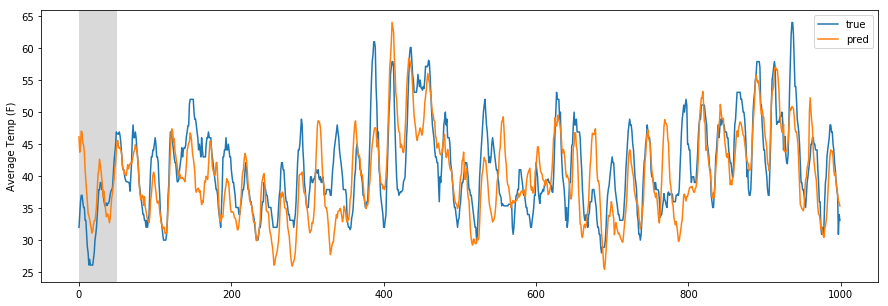

In [54]:
plot_comparison(start_idx=10000, length=1000, train=True)

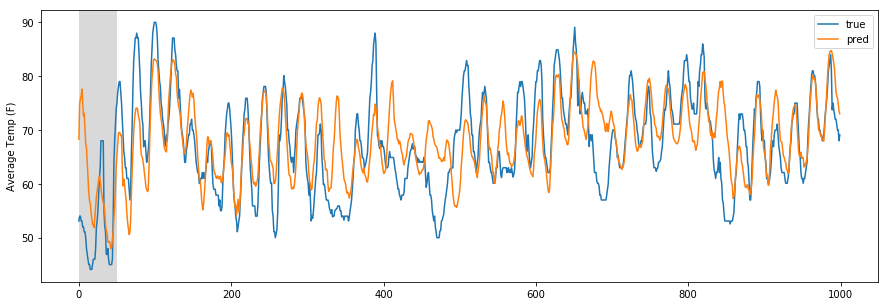

In [55]:
plot_comparison(start_idx=200, length=1000, train=False)

# Results

Different data used

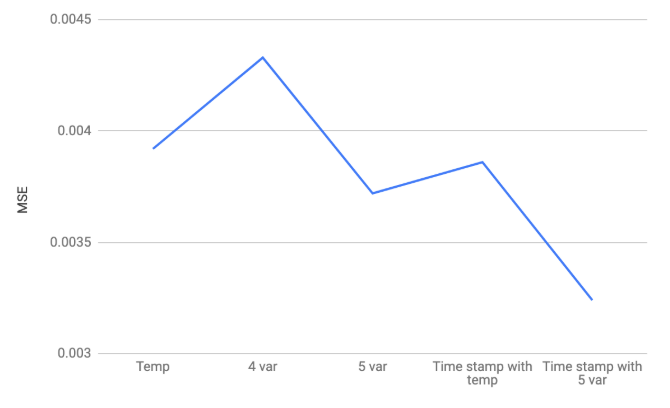

In [2]:
from IPython.display import Image
Image("./result1.png")

Different time used

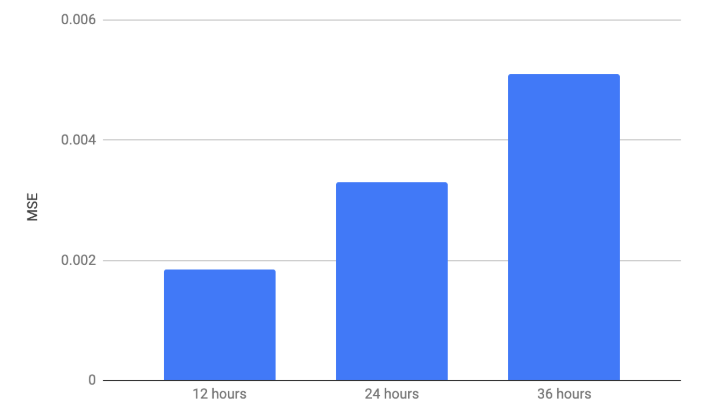

In [3]:
Image("./result2.png")

In [145]:
def errorplot(x_test_scaled, y_test, train = False):
    pred = y_scaler.inverse_transform(model.predict(np.expand_dims(x_test_scaled, axis=0))[0])[100:].flatten()
    true = y_test[100:].flatten()
    fixedindex = df_merge.index[(-1*(len(x_test_scaled)))+100:]
    trainindex = df_merge.index[:len(x_test_scaled)-100]
    df_error = pd.DataFrame({'pred':pred,'true':true})

    if train == True:
        df_error["Date/Time (GMT)"] = fixedindex
    else:
        df_error["Date/Time (GMT)"] = trainindex
            
    df_error = df_error.set_index(pd.DatetimeIndex(df_error[df_error.columns[2]]))
    df_error = df_error.drop(columns=["Date/Time (GMT)"])

    df_error['hours'] = df_error.index.hour
    df_error['error'] = (df_error['pred']-df_error['true']).abs()
    df_error_dif = (df_error.groupby('hours').sum())/int(len(df_error)/7)
    df_error_dif.plot(y='error', use_index=True)
    plt.show()
    

This plot is for testing. As you can see, the error was highest in predicting the temperature in 8pm

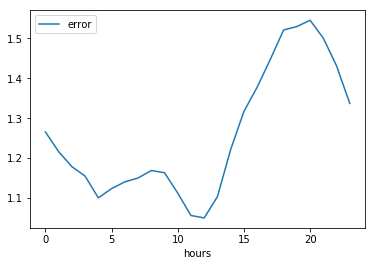

In [146]:
errorplot(x_test_scaled, y_test,True)

This plot is for training. As you can see, the error was highest in predicting the temperature in 3pm

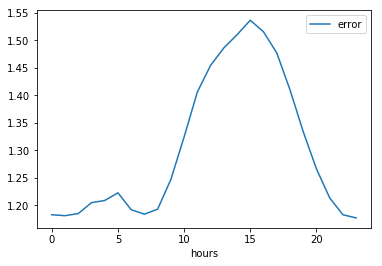

In [148]:
errorplot(x_train_scaled, y_train)

# Scaled data for RF
We are building random forest to check the feature importance (what kind of variable is most influential in predicting temperature?


In [167]:
d = {'kphl' : df_kphl_useful, 
     'kabe' : df_kabe_useful, 
     'kacy' : df_kacy_useful,
     'klns' : df_klns_useful,
     'kttn' : df_kttn_useful,
     'target' : df_targets}
df_merge = pd.concat(d.values(), axis=1, keys=d.keys())

In [169]:
x_scaler = MinMaxScaler()
x = np.nan_to_num(df_merge)

In [170]:
x_scaled = x_scaler.fit_transform(x)

In [171]:
X = x_scaled[:,0:-1]
y = x_scaled[:,-1]

# fit random forest model


In [172]:
model = RandomForestRegressor(n_estimators=1000, random_state=1)
model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [173]:
importance = model.feature_importances_
importance

array([0.19932542, 0.00669647, 0.00527561, 0.00346965, 0.00502063,
       0.00159859, 0.02317034, 0.0058209 , 0.00431267, 0.00788867,
       0.00469238, 0.00159948, 0.00733421, 0.00776067, 0.00501859,
       0.01320705, 0.00499052, 0.00159752, 0.63097702, 0.00574086,
       0.00500698, 0.01000167, 0.01084647, 0.00160266, 0.00584324,
       0.00546282, 0.00452589, 0.00538709, 0.00423406, 0.00159186])

In [174]:
station_importance = [0,0,0,0,0]
station = ['KPHL','KABE','KACY','KLNS','KTTN']
for i in range(len(model.feature_importances_)):
    station_importance[i//6] += importance[i]

In [175]:
ticks = [i for i in range(len(station))]

This graph tells us that lancaster station was most influential in predicting the temperature in philadelphia station (24 hours ahead)

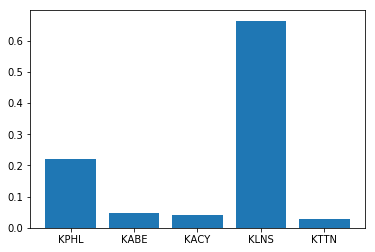

In [176]:
pyplot.bar(ticks, station_importance)
pyplot.xticks(ticks, station)
pyplot.show()

In [177]:
feature_importance = [0,0,0,0,0,0]
feature = ['Temp','Humidity','Wind speed','Pressure','Wind direction','hours']

for i in range(len(model.feature_importances_)):
    if i == 0:
        feature_importance[i] += importance[i]
    else:
        feature_importance[i%6] += importance[i]

When we predicted temperature ahead, the previous temperature was most influeitnal.

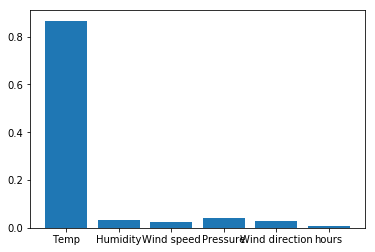

In [178]:
ticks = [i for i in range(len(feature))]

pyplot.bar(ticks, feature_importance)
pyplot.xticks(ticks, feature)
pyplot.show()